# Scikit-Learn for Dask Arrays
### 1. Adapt scikit-learn to dask (adapting <code>partial_fit</code> methods)
### 2. Examples
    * Incremental k-means for lava flow images
    * Iris data set k-means clustering with dask arrays
    * Stochastic gradient descent classifier

In [1]:
%matplotlib inline
from __future__ import print_function, division
import inspect
import itertools
import dask.array as da
import matplotlib.pyplot as plt
import numpy as np
import random
import re
from pprint import pprint
import sys
import tarfile
import time
from dask.array.core import rec_concatenate, Array
from functools import partial
from itertools import count
from operator import getitem
from pprint import pformat
from sklearn.cluster import MiniBatchKMeans
from sklearn.datasets import get_data_home
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.externals.six.moves import html_parser
from sklearn.externals.six.moves import urllib
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import SGDRegressor
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from skimage.transform import resize
from toolz import merge

import matplotlib.lines as mlines
from matplotlib.patches import Rectangle


import requests
try:
    from StringIO import StringIO
except ImportError:
    from io import BytesIO as StringIO
from PIL import Image


### A dictionary of the sci-kit learn classes that could be supported.  
* Each of these has a <code>partial_fit</code> method.
* The partial fit methods are standardized by the <code>DaskMLBase</code> class below

In [2]:
x_names  = ('X-sample-%d' % i for i in count(1))
y_names  = ('Y-sample-%d' % i for i in count(1))
w_names  = ('Weight-sample-%d' % i for i in count(1))
pred_names  = ('Predict-%d' % i for i in count(1))
partial_fit_algos = {
    'SGDClassifier': SGDClassifier,
    'SGDRegressor':SGDRegressor,
    'Perceptron': Perceptron,
    'PassiveAggressiveClassifier': PassiveAggressiveClassifier,
    'PassiveAggressiveRegressor':PassiveAggressiveRegressor,
    'MultinomialNB': MultinomialNB,
    'BernoulliNB': BernoulliNB,
    'MiniBatchDictionaryLearning': MiniBatchDictionaryLearning,
    'MiniBatchKMeans': MiniBatchKMeans,
}


### A common base class to abstract <code>partial_fit</code> methods.

In [3]:
class DaskMLBase(object): 
    """Classes by the same name as sklearn classes
    inherit from DaskMLBase.

    It standardizes the partial_fit methods 
    of sklearn classes for use with dask arrays. 

    Parameters:

        Positional args:
            args_to_cls: list/tuple
                args that go to the original sklearn class
                initialization, typically []
            kwargs_to_cls: dict 
                kwargs that go to the original sklearn class
                initialization. see sklearn docs
            X: 2-d dask array
                Training data X.  X will be reblocked (see below).
        Keywork args:
            Y: 1-d or 2-d dask array:
                True Y samples, 1- or 2-d,
                depending on sklearn class.
                Y.shape[0] === X.shape[0] 
                Y is reblocked (see below)
            sample_weight: None/1-d dask array 
                sample weights to be applied in 
                training, if any.
                sample_weight.shape[0] === X.shape[0]
            sample_gridx: int 
                the regular blockshape (row count) 
                to which the X,Y, sample_weight
                should be reblocked. If 2-d there is only 1 block
                in the column dimension.
            batch_size: int
                How many rows to use for each sample 
                (This is automatically inserted in 
                    kwargs_to_cls when needed.)
            n_batches: int 
                How many batches of samples.
            callback: None/callable
                Run this on each batch
    """
    # These are the methods that require
    # all possible classes to be known in advance.
    requires_all_classes = ('MultinomialNB','BernoulliNB',
                            'Perceptron','SGDClassifier',
                            'PassiveAggressiveClassifier')
    cls_str = None # to over-ride this in each class
    def __init__(self, 
                args_to_cls, 
                kwargs_to_cls, 
                X, 
                Y=None,
                sample_weight=None,
                sample_gridx=500,
                batch_size=10000,
                n_batches=10,
                callback=None):
         # save params
        self.sample_gridx = sample_gridx
        self.batch_size = batch_size
        self.n_batches = n_batches
        self.callback = callback
       
        # get the class object
        self.cls = partial_fit_algos[self.cls_str]
        # reblock the row dimension uniformly of X
        self.X = X.reblock(blockshape=(sample_gridx, X.shape[1])) 
        # reblock sample_weight if given
        if sample_weight is not None:
            self.sample_weight = sample_weight.reblock(blockshape=(sample_gridx,))
        else:
            self.sample_weight = None
        # determine whether Y (true samples)
        # is given and its dimension if so.
        if (Y is not None) and len(Y.shape) == 2:
            yb = (sample_gridx, Y.shape[1])
        else:
            yb = (sample_gridx,)
        # make sure X, Y, sample_weights
        # are all on same row blocks.
        if Y is not None:
            self.Y = Y.reblock(blockshape=yb)
        else:
            self.Y = None
        # automate some initialization
        # of classes for ml
        try:
            self.spec = inspect.getargspec(
                            self.cls.__init__
                        ).args
        except:
            self.spec = {}
        if 'batch_size' in self.spec:
            kwargs_to_cls['batch_size'] = batch_size
        # initialize model
        self.model = self.cls(*args_to_cls, 
                                **kwargs_to_cls)
        # initialize scores and history
        try:
            self.score_spec = inspect.getargspec(
                                    self.model.score
                                ).args
        except:
            self.score_spec = {}
        self.stats = {
                     'iter_offset': 0, 
                     'score': 0.0,
                     'history': [], 
                     't0': time.time(),
                     'total_fit_time': 0.0,
            }
        

    def __repr__(self):
        s = pformat(self.stats)
        return "Model:\n%r\nStats:\n%s\n"%(self.model, s)
    def _row_getter(self, name, getarg, twod=True):
        """row_getter(self, name, getarg, twod=True)
        Internal utility for forming slices 
        needed in dask array DAG's
        
        It is assumed if 2-d, there is only one block
        in second (column) dimension.
        
        Parameters:
            name: str
                name of output dask array
            getarg: tuple
                arg that goes to getitem, e.g.
                ('x_1', 0, 0) for a 2-d array x_1
            twod:
                True if 2-d output dask array else False
                
        """
        key = (name,0)
        sli = slice(None, None, None)
        if twod:
            key += (0,)
            slic = (sli,sli)
        else:
            slic = sli
        return (key, (getitem, getarg, slic))
        
    def get_sample(self):
        """Full slices of blocks are taken until
        batch_size is met.
        
        Some randomization comes from randomizing the block indicies,
        and taking full blocks, where the randomized block indicies are 
        based on the X, Y, and sample_weight dask arrays after initial
        reblocking.  The initial reblocking changes the
        the row (axis 0) dimension to sample_gridx.  It is better at 
        this point if data are pre-sorted randomly before forming 
        the X, Y, sample_weight dask arrays.
         """
        cat_args = []
        xname = next(x_names)
        if self.Y is not None:
            yname = next(y_names)
        else:
            yname = None
        if self.sample_weight is not None:
            swname = next(w_names)
        else:
            swname = None
        choices = tuple(range(self.sample_gridx))
        # all possible row blocks
        blks = list(range(len(self.X.blockdims[0])))
        # randomize the keys to all blocks
        np.random.shuffle(blks)
        # take up to the first 'limit' block ids
        limit = self.batch_size / self.sample_gridx
        limit = int(np.ceil(limit))
        # assess whether Y is 2d if needed
        ytwod = len(self.Y.shape) == 2 if self.Y is not None else False
        for blk_row_idx in blks[:limit]: # for each random block chosen
            indx =  (self.X.name, blk_row_idx, 0)  # a key into the X dask
            if self.Y is not None:
                indy = (self.Y.name, blk_row_idx)  # a key into the Y dasky
                if ytwod:                         # Y may or may not be 2d
                    indy += (0,)                  # at 0 (single block in column dimension)
            else:
                indy = None
            if self.sample_weight is not None:
                indsw = (self.sample_weight.name, blk_row_idx) # dask key for sample_weight
            else:
                indsw = None
            inds = (indx, indy, indsw)
            names = (xname, yname, swname)
            in_self = ('X','Y','sample_weight')
            twods = (True, ytwod, False)
            cat_args = {'X': [],'Y': [],'sample_weight': []}
            for name, ind, twod, self_ident in zip(names, inds, twods, in_self):
                if ind is None:
                    continue  # may be not using y or sample_weight
                k,v = self._row_getter(name, ind, twod=twod)  # full_key, getitem ....
                if twod:
                    this_shape = (self.sample_gridx, self.__dict__[self_ident].shape[1])
                else:
                    this_shape = (self.sample_gridx,)
                # get the block that is part of sample. compute it to 1d or 2d np array
                arr = Array(merge({k: v}, self.__dict__[self_ident].dask),
                            name,
                            shape=this_shape,
                            blockshape=this_shape
                        ).compute()
                # append that block to the list that will be concatenated
                cat_args[self_ident].append(arr)
        sample_x = np.concatenate(cat_args['X'])
        # The following are row stacks of the sample blocks to the full sample
        if self.Y is not None:
            sample_y = np.concatenate(cat_args['Y'])
        else:
            sample_y = None
        if self.sample_weight is not None:
            sample_weight = np.concatenate(cat_args['sample_weight'])
        else:
            sample_weight = None
        return (sample_x, sample_y, sample_weight)
    def get_all_classes(self):
        """ Overriding this method is required 
        if using an sklearn method that requires 
        all possible classes to be known in advance."""
        raise ValueError(
                """Override get_all_classes to return 
all possible classes as list.  Required for %r
See sklearn docs. """ % self.cls)

    def partial_fit(self):
        """ 
        partial_fit(self)

        Standardizes arguments to partial_fit methods of 
        sklearn classes to allow X, Y, and sample_weight 
        to be dask arrays.

        """
        samp = self.get_sample()
        sample_x, sample_y, sample_weight = samp
        if self.cls_str in self.requires_all_classes:
            kwargs = {'classes': self.get_all_classes()}
        else:
            kwargs = {}
        if 'sample_weight' in self.spec and self.sample_weight is not None:
            kwargs['sample_weight'] = sample_weight
        if 'iter_offset' in self.spec:
            kwargs['iter_offset'] = self.stats['iter_offset']
        if not kwargs:
            self.model.partial_fit(sample_x, sample_y)
        else:
            self.model.partial_fit(sample_x, sample_y, **kwargs)
        self.stats['iter_offset'] += sample_x.shape[0]
        if hasattr(self.model, 'score'):
            score_args = [sample_x]
            if 'y' in self.score_spec or 'Y' in self.score_spec:
                score_args.append(sample_y)
            if 'sample_weight' in self.score_spec:
                self.stats['score'] = self.model.score(*score_args, 
                                        sample_weight=sample_weight)
            else:
                self.stats['score'] = self.model.score(*score_args)
            self.stats['history'].append((self.stats['iter_offset'], self.stats['score']))
        self.stats['total_fit_time'] = time.time() - self.stats['t0']
        if callable(self.callback): 
            self.callback()
    
    def fit(self):
        for step in range(self.n_batches):
            self.partial_fit()
            self.step = step
            if self.stop():
                break
        scores = ([h[1] for h in self.stats['history']])
        self.stats['score_summary'] = {
            'mean': np.mean(scores),
            'median': np.median(scores),
            'min': np.min(scores),
            'max': np.max(scores),
        }
    def stop(self):
        """ Override this if needed.
        Return True to stop after a partial_fit
        step.
        """
        return False
    def predict_dask(self, X=None):
        """ 
        predict_dask(self, X=None)
        
        
        Run the predict method using X given
        as kwarg, falling back to self.X (X given
        at initialization).
        
        Parameters
            X: 2-d dask array / None
                The predict method of the sklearn class
                is used on X, a dask array.
        """ 
        dsk = {}
        using_X = X  if X is not None else self.X
        name = next(pred_names)
        for k in using_X.dask:
            if using_X.name == k[0]:
                dsk[(name, ) + k[1:]] = (self.model.predict, (getitem, k, slice(None, None, None)))
        return Array(merge(dsk, using_X.dask), name, shape=using_X.shape, blockdims=using_X.blockdims)
    

### Define machine learning classes for dask
* Inherit from the base class above that handles the <code>partial_fit</code> methods
* Use one of the strings from <code>partial_fit_algos = {...} </code> dictionary above to get a model class name
* Then the class can be initialized with dask interface

In [4]:
class SGDClassifier(DaskMLBase):
    cls_str = 'SGDClassifier'

class SGDRegressor(DaskMLBase):
    cls_str = 'SGDRegressor'

class Perceptron(DaskMLBase):
    cls_str = 'Perceptron'

class PassiveAggressiveClassifier(DaskMLBase):
    cls_str = 'PassiveAggressiveClassifier'

class PassiveAggressiveRegressor(DaskMLBase):
    cls_str = 'PassiveAggressiveRegressor'

class MultinomialNB(DaskMLBase):
    cls_str = 'MultinomialNB'

class BernoulliNB(DaskMLBase):
    cls_str = 'BernoulliNB'

class MiniBatchDictionaryLearning(DaskMLBase):
    cls_str = 'MiniBatchDictionaryLearning'

class MiniBatchKMeans(DaskMLBase):
    cls_str = "MiniBatchKMeans"


# Using the learning classes
## Examples

### Classifying synthetic data from the sklearn <code>make_blobs</code> function 
* Using stochastic gradient descent classifier 

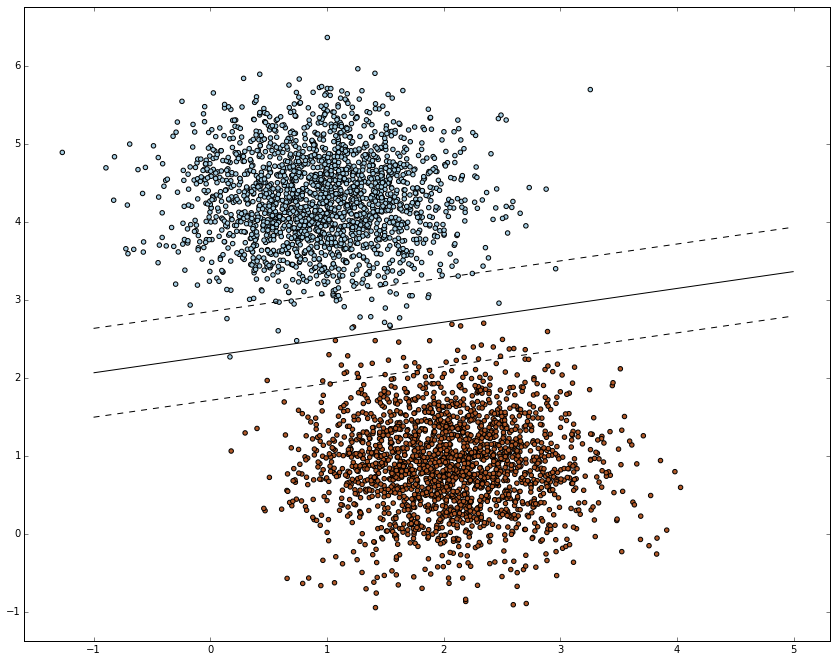

In [5]:
from sklearn.datasets.samples_generator import make_blobs

# generated data for example
Xn, Yn = make_blobs(n_samples=4000, centers=2, random_state=0, cluster_std=0.60)


X = da.from_array(Xn, shape=Xn.shape, blockshape=(10, Xn.shape[1]))
Y = da.from_array(Yn, shape=(Yn.size,), blockshape=(10, ))
# fit the model
clf = SGDClassifier([],
                    {'loss':"hinge", 
                     'alpha':0.01, 
                     'n_iter':200, 
                     'fit_intercept':True,},
                    X,
                   **{   
                        'batch_size': 2000,       # sample size - each batch
                        'n_batches': 5,           # how many batches
                        'sample_gridx': 400,      # to what row count should the row dimension be reblocked
                        'Y': Y
                    })
clf.get_all_classes = lambda: [0,1]
clf.fit()

xx = np.linspace(-1, 5, 10)
yy = np.linspace(-1, 5, 10)

X1, X2 = np.meshgrid(xx, yy)
Z = np.empty(X1.shape)
for (i, j), val in np.ndenumerate(X1):
    x1 = val
    x2 = X2[i, j]
    p = clf.model.decision_function([x1, x2])
    Z[i, j] = p[0]
levels = [-1.0, 0.0, 1.0]
linestyles = ['dashed', 'solid', 'dashed']
colors = 'k'
fig = plt.figure(figsize=(14,11))
ax = fig.add_axes((.1,.1,.8,.8))
ax.contour(X1, X2, Z, levels, colors=colors, linestyles=linestyles)
ax.scatter(X[:, 0].compute(), X[:, 1].compute(), c=Y.compute(), cmap=plt.cm.Paired)
ax.axis('tight')
plt.show()

### The modified Iris kmeans example from sklearn is below
* The main change in interface is where the <code>X</code> and <code>Y</code> matricies/columns are given
* In sklearn the <code>fit</code>, <code>partial_fit</code>, and <code>predict</code> methods take and <code>X</code> and sometimes <code>Y</code> arguments
* The change is to take <code>X</code> and <code>Y</code> dask arrays at initialization

In [6]:
from sklearn import datasets
centers = [[1, 1], [-1, -1], [1, -1]]
iris = datasets.load_iris()

# X and Y are dask arrays
X = da.from_array(iris.data, shape=iris.data.shape, blockshape=(200, iris.data.shape[1]))
y = da.from_array(iris.target, shape=iris.target, blockshape=(200, ))


kwargs_to_cls = {'max_iter': 100,    #iterations per block of sampling
                'n_clusters': 3,}    # how many clusters to find.


kwargs = {   
            'batch_size': 100,       # sample size - each batch
            'n_batches': 4,           # how many batches
            'sample_gridx': 100, # to what row count should the row dimension be reblocked
            'Y': y,              # training dask Y
        }
km = MiniBatchKMeans([], kwargs_to_cls, X, **kwargs)

# Run partial_fit n_batches times
km.fit()

print('Iris data centroids:')
pprint(km.model.cluster_centers_)

Iris data centroids:
array([[ 5.61260504,  2.64705882,  3.99159664,  1.22773109],
       [ 5.006     ,  3.418     ,  1.464     ,  0.244     ],
       [ 6.41111111,  2.95061728,  4.65432099,  1.47037037]])



### Another example: image analysis (Holuhraun Lava Field, Icefield): 
<img src="http://eoimages.gsfc.nasa.gov/images/imagerecords/85000/85031/holuhraun_oli_2015003_swir_lrg.jpg" style="height:200px;width:255px;left:-360px;position:relative;"></img>.  
### Read more <a href="http://earthobservatory.nasa.gov/IOTD/view.php?id=85031">here</a> and <a href="http://earthobservatory.nasa.gov/Images/category.php?cat_id=2">here</a>
#### Classify and count land cover types and lava extent in Landsat 8 infrared images

* A function for detecting which centroid from kmeans most looks like lava (Pareto ranks using 2 bands)

In [7]:
def pareto_find_lava(cens):
    blu = cens[:,0]
    blu = blu * np.ones((blu.size,1))
    red = cens[:,2]
    red = red * np.ones((red.size,1))
    logic_blu = np.zeros(blu.shape)
    logic_blu[blu < blu.T] = 1
    logic_red = np.zeros(red.shape)
    logic_red[red > red.T] = 1
    lava_ranks = np.sum(logic_blu + logic_red, axis=0)
    return lava_ranks


* Function for getting an image from a uri, returning image and dimensions

In [8]:
def get_image_uri(uri):
    r= requests.get(uri)
    s=StringIO(r._content)
    pill = Image.open(s)
    im_orig = np.asarray(pill, dtype=np.uint8) / 256.0
    w_orig, h_orig, d_orig = im_orig.shape
    return im_orig, w_orig, h_orig, d_orig


* A function for image preview

In [16]:
def preview(im_orig, w_orig, h_orig, d_orig, msg):
    im_downsize = im_orig[::fac,::fac,:]
    xwidth = 14
    fig = plt.figure(figsize=(xwidth, h_orig/w_orig * xwidth))
    plt.title("%s - Preview: (Image shape = %r)" % (msg, im_orig.shape,))
    fig.gca().imshow(im_downsize)

* Get an image that will go into kmeans as training for land cover / lava classes
* Later train on a region of the image (see the indicices to <code>im_orig</code> below)

In [17]:
init_uri  = "http://eoimages.gsfc.nasa.gov/images/imagerecords/84000/84431/holuhraunflows_ali_2014263_ir_lrg.jpg"
fac = 8                                                          # downsample for preview
out1 = get_image_uri(init_uri)        # read a uri
im_orig, w_orig, h_orig, d_orig = out1
im = im_orig[50 * fac: 75 * fac, 0 * fac: 100 * fac]
w,h,d = im.shape
X = da.from_array(im.reshape((w * h, d)), shape=(w * h, d), blockshape=( (w * h) // 8, d))

* Get a 2nd similar image 
* Later classify and count pixels in the 2nd image using the kmeans centroids from the 1st

In [18]:
uri_2 = "http://eoimages.gsfc.nasa.gov/images/imagerecords/85000/85031/holuhraun_oli_2015003_swir_lrg.jpg"
out2 = get_image_uri(uri_2)

* Run kmeans on the first image
* And print the found centroids

In [19]:
kwargs_to_cls = {
                'max_iter': 150,
                'n_clusters': 11,
                'random_state': 0,
                }
default_kwargs = {   
            'batch_size': 50000,       # sample size - each batch
            'n_batches': 8,           # how many batches
            'sample_gridx': 8000,      # to what row count should the row dimension be reblocked
           # sample_weight':           # dask array sample_weight can be given,
        }
km = MiniBatchKMeans([], kwargs_to_cls, X, **default_kwargs)
km.fit()
print('Centroids:')
pprint(km.model.cluster_centers_)

Centroids:
array([[  3.10274704e-01,   3.01057187e-01,   2.77621741e-01],
       [  9.93874081e-01,   9.46204044e-01,   5.29719669e-01],
       [  6.29146499e-05,   9.06231745e-05,   1.75378661e-04],
       [  7.85924306e-01,   6.21371758e-01,   5.27890342e-01],
       [  2.11152896e-01,   2.11405546e-01,   1.93466396e-01],
       [  6.00574237e-01,   2.95749928e-01,   2.05875576e-01],
       [  9.55590957e-01,   5.78896066e-01,   2.58893932e-01],
       [  9.51026786e-01,   7.38973214e-01,   5.58200893e-01],
       [  5.01319765e-01,   4.02432866e-01,   4.14847569e-01],
       [  9.85775497e-01,   9.93868096e-01,   9.13252483e-01],
       [  1.59458138e-01,   1.54613736e-01,   1.23675505e-01]])


* Now make dask arrays representing full images, label each pixel, and count each class

In [20]:
def predict(im_orig, w_orig, h_orig, d_orig):
    orig_flat = im_orig.reshape((w_orig * h_orig, d_orig))
    labels = km.predict_dask(
            da.from_array(orig_flat, shape=orig_flat.shape, blockshape=(orig_flat.shape[0] // 8, 3))
        )
    dsk = {}
    name = 'count_classes'
    lenn = km.model.cluster_centers_.shape[0]
    bincount_fixed = lambda x: np.array(np.bincount(x, minlength=lenn),ndmin=2)
    cnt = 0
    cat_args= []
    bd = 40000
    xblocks = []
    for key in labels.dask:
        if labels.name == key[0]:
            cat_args.append((bincount_fixed, (getitem, key, slice(None, None, None))))
            if len(cat_args) >= bd:
                dsk[(name, cnt, 0)] = (rec_concatenate, cat_args)
                xblocks.append(len(cat_args))
                cnt += 1
                cat_args = []
    if cat_args:
        dsk[(name, cnt, 0)] = (rec_concatenate, cat_args)
        xblocks.append(len(cat_args))
    cover_counts = Array(merge(dsk, labels.dask), name, blockdims=(tuple(xblocks), (lenn,)))
    return cover_counts

* Sum the pixels as labeled and make a bar chart

In [31]:
def cover_count_figures(km, im_orig, w_orig, h_orig, d_orig, msg):
    cc = predict(im_orig, w_orig, h_orig, d_orig).compute()
    pixel_counts_of_cover = np.sum(cc, axis=0)
    cumsum_pix = np.cumsum(pixel_counts_of_cover) / sum(pixel_counts_of_cover) * 100
    fig = plt.figure(figsize=(14,11))
    ax = fig.add_axes((.1,.1,.8,.8))
    ax.bar(list(range(len(km.model.cluster_centers_))), 
           pixel_counts_of_cover, 
           color = km.model.cluster_centers_,
          log=1)
    ax.set_xticks(list(range(len(km.model.cluster_centers_))))
    plt.title('Pixel counts in each k-means cluster')
    ax.grid(b=True, which='both', color='0.65',linestyle='-', alpha=.5)
    plt.show()
    cens = km.model.cluster_centers_
    ascend_red_descend_blue = pareto_find_lava(cens)
    idx_of_lava_class = np.argmin(ascend_red_descend_blue)
    lava_pix_count = pixel_counts_of_cover[idx_of_lava_class]
    print('In', msg.lower(), ', there are', lava_pix_count,'lava pixels in full image')

* Make a preview of each image, then a bar chart of the cover counts in each image

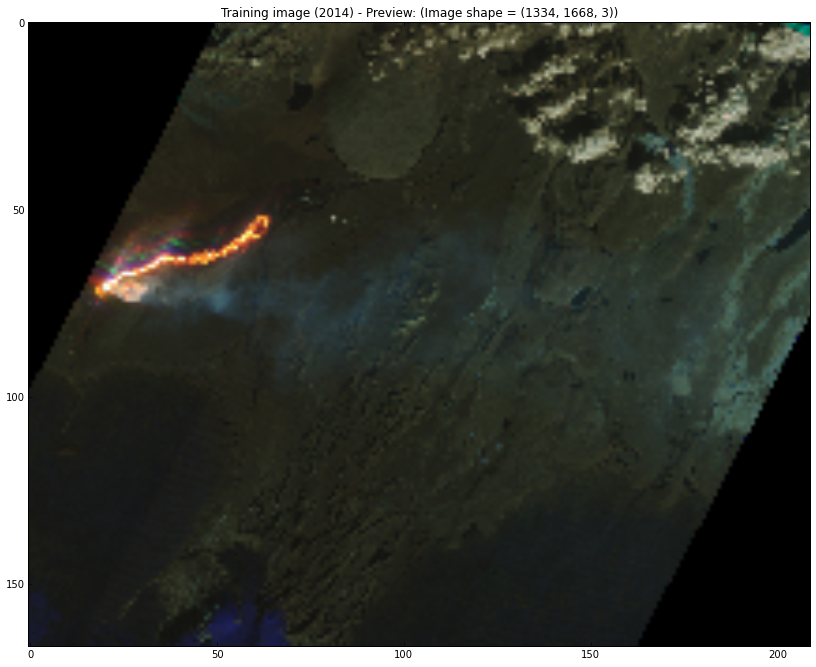

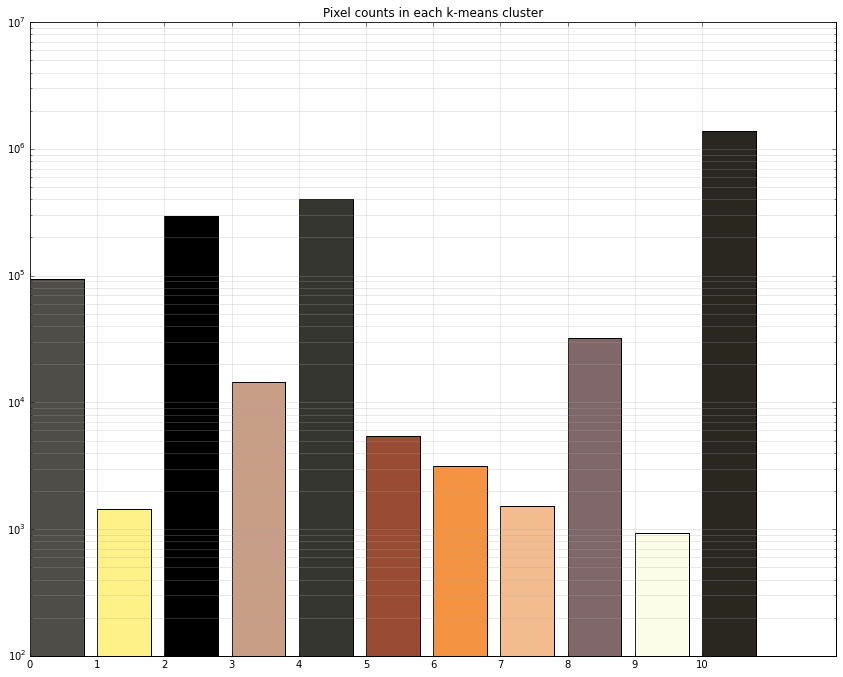

In training image (2014) , there are 3144 lava pixels in full image


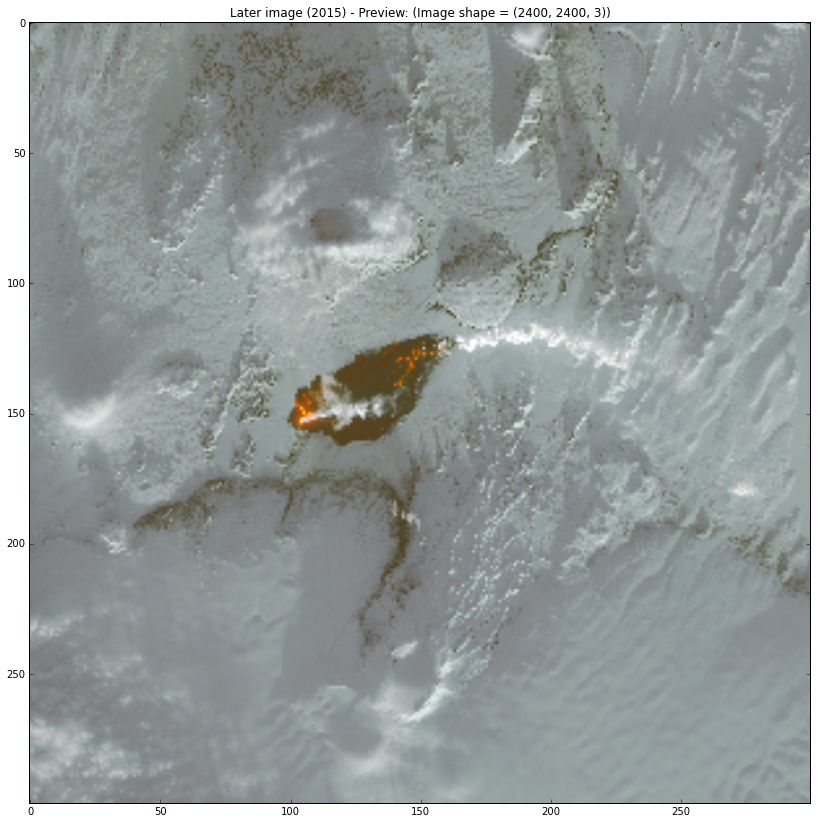

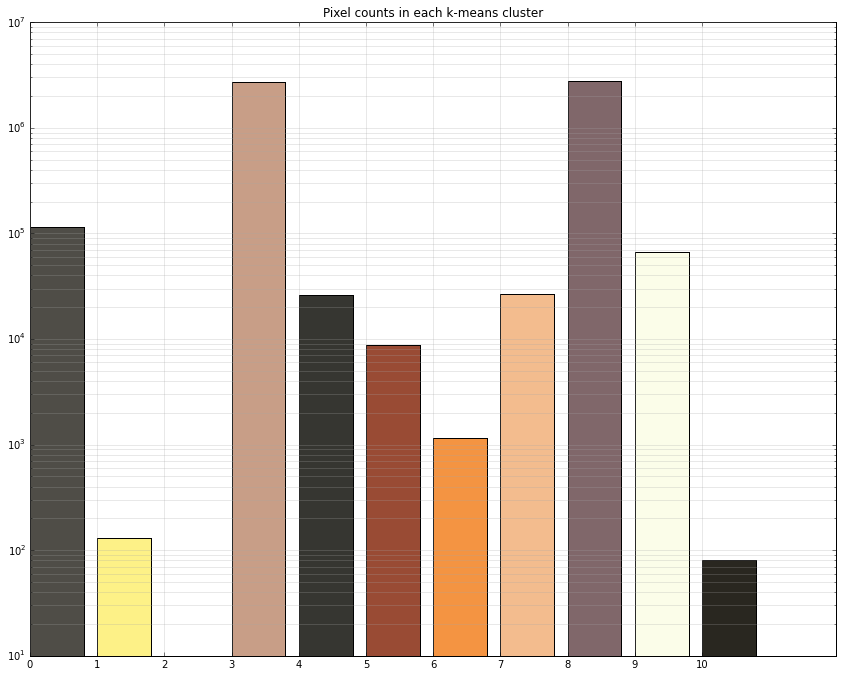

In later image (2015) , there are 1144 lava pixels in full image


In [32]:
msgs = ('Training image (2014)', 'Later image (2015)')
for ((i,w,h,d), msg) in zip((out1, out2), msgs):
    preview(i, w, h, d, msg)
    cover_count_figures(km, i, w, h, d, msg)